## Exercise 1.2
## Classification of MNIST digits with a convolutional neural network

In this exercise we will classify MNIST digits again, but this time we will use a convolutional neural network (CNN).

First we import the modules we need

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We check that this script has a GPU available

In [2]:
if torch.backends.mps.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

The code will run on GPU.


In [3]:
device

device(type='mps')

We import the MNIST dataset, which is built into pytorch

In [4]:
# Define transformers
transformers = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=20), # try 40
    transforms.RandomPerspective(distortion_scale=0.3) # try 0.9
])

In [5]:
batch_size = 64
trainset = datasets.MNIST('./data', train=True, download=True, transform=transformers)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1) # Original: num_workers=1
testset = datasets.MNIST('./data', train=False, download=True, transform=transformers)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=1) # Original: num_workers=1

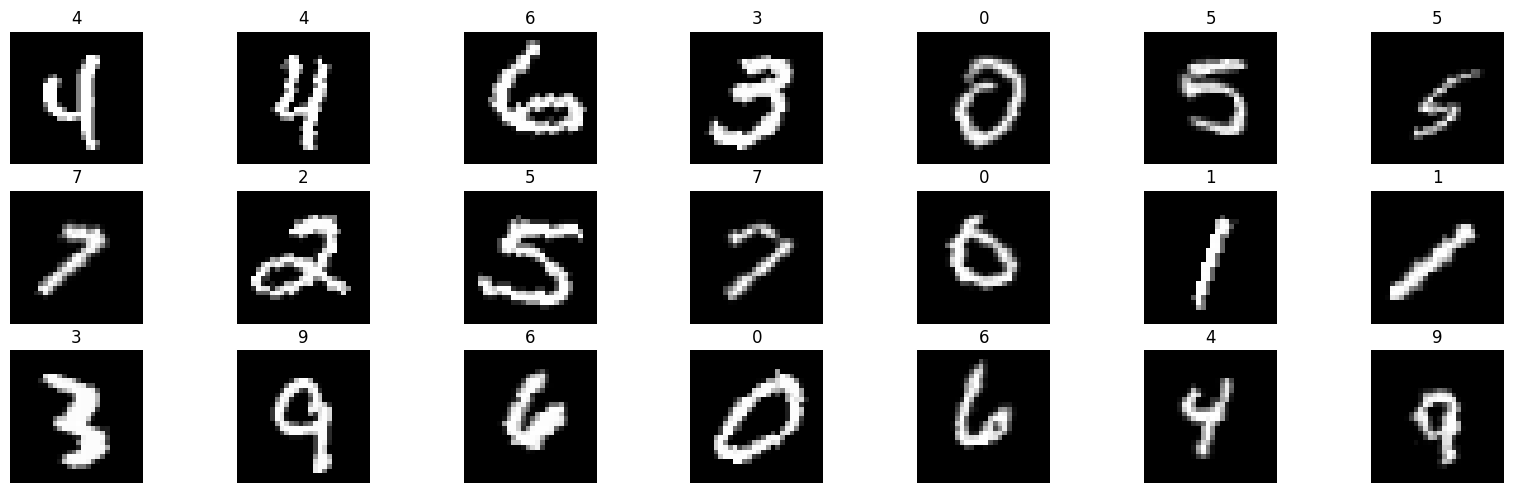

In [6]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

You should implement a network to classify MNIST digits. 
The network should consist of two parts, a part with convolutions and one with fully connected layers.
The convolutional part we will call `convolutional`, and it should contain the follwing:
* two convolutional layers with 8 features
* a $2\times2$ max pooling layer
* two convolutional layers with 16 features

The convolutions should be $3\times 3$, and should not change the size of the output. What does this mean that the stride and padding should be? Stride=1 and padding=1

For example check the documentation of the `nn` module https://pytorch.org/docs/stable/nn.html

**Remember**: There's a specific type of layer that you should always have after a convolution or a fully connected layer. What is this type of layer called?

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(1, 8, 3, 1, 1),
                nn.Dropout(p=0.5),
                nn.ReLU(),
                nn.Conv2d(8, 8, 3, 1, 1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(8, 16, 3, 1, 1),
                nn.ReLU(),
                nn.Conv2d(16, 16, 3, 1, 1),
                nn.ReLU()
                ) # isnt it 

        self.fully_connected = nn.Sequential(
                nn.Linear(14*14*16, 500),
                nn.ReLU(),
                nn.Linear(500, 10),
                nn.Softmax(dim=1))
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

We instantiate a copy of our network, transfer it to the GPU if it's available.
We also check if the dimensions of our network match.

In [8]:
model = Network()
model.to(device)
#Initialize the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#Get the first minibatch
data = next(iter(train_loader))[0].to(device)
#Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit

Shape of the output from the convolutional part torch.Size([64, 16, 14, 14])


We train this network for five epochs

In [9]:
num_epochs = 5

for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = F.nll_loss(torch.log(output), target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    model.eval()
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = output.argmax(1).cpu()
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 77.2%	 test: 93.1%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 95.1%	 test: 95.3%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 96.5%	 test: 96.7%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 97.0%	 test: 96.6%


  0%|          | 0/938 [00:00<?, ?it/s]

Accuracy train: 97.5%	 test: 96.9%


Hopefully you now have a model that's able to achieve decent performance on MNIST.
It should have around 97.5% accuracy on the test set after the first epoch.

* Why is the accuracy on the training set higher than on the test set? (recall from machine learning)
It learns from the training set so it knows it distribution. This makes it better at predicting the train set as it knows it. The test set is unknown data which potentially does not follow the same patterns/distribution. 

* Why does it have higher accuracy on the test set than the training set after the first epoch?

   hint: it's related to how the train accuracy is computed
In the first epoch the neural network will learn as we progress through the batches. In the first batches the network will predict randomly as it have not learned any patterns yet. This will probably result in bad predictions especially in the beginning of the epoch. The test set is on the other hand predicted by a neural network that has been trained on all the train data once making it possible to predict better. The discrepency is caused by the way the training accuracy is computed/defined in this example. 

### Data augmentation
 * Add random rotations to the MNIST digits during training (you have to go back and modify the dataloader)
 
  hint: you can use `transforms.RandomRotation` 
  
  hint: you can combine multiple transforms into one with `transforms.Compose`

How does this affect your training and testing loss?
Still pretty good.

 * Try plotting some of the augmented images, to visually confirm what your augmentation is doing.
Done in the top!
 * Try adding another type of data augmentation.
Added RandomPerspective

### Explore the model
What has the model learned? You can access all the weights in the model with `model.parameters()`. Here we just print the shape.
 - Try showing images of the filters in the first layer. 
 - Can you from the dimensions of the weights alone identify which layer it is in our model? Yes

In [10]:
[w.shape for w in model.parameters()]

[torch.Size([8, 1, 3, 3]),
 torch.Size([8]),
 torch.Size([8, 8, 3, 3]),
 torch.Size([8]),
 torch.Size([16, 8, 3, 3]),
 torch.Size([16]),
 torch.Size([16, 16, 3, 3]),
 torch.Size([16]),
 torch.Size([500, 3136]),
 torch.Size([500]),
 torch.Size([10, 500]),
 torch.Size([10])]

In [11]:
conv1 = model.convolutional[0].weight.data.cpu().numpy()

In [12]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = conv1.min(), conv1.max()
filters = (conv1 - f_min) / (f_max - f_min)

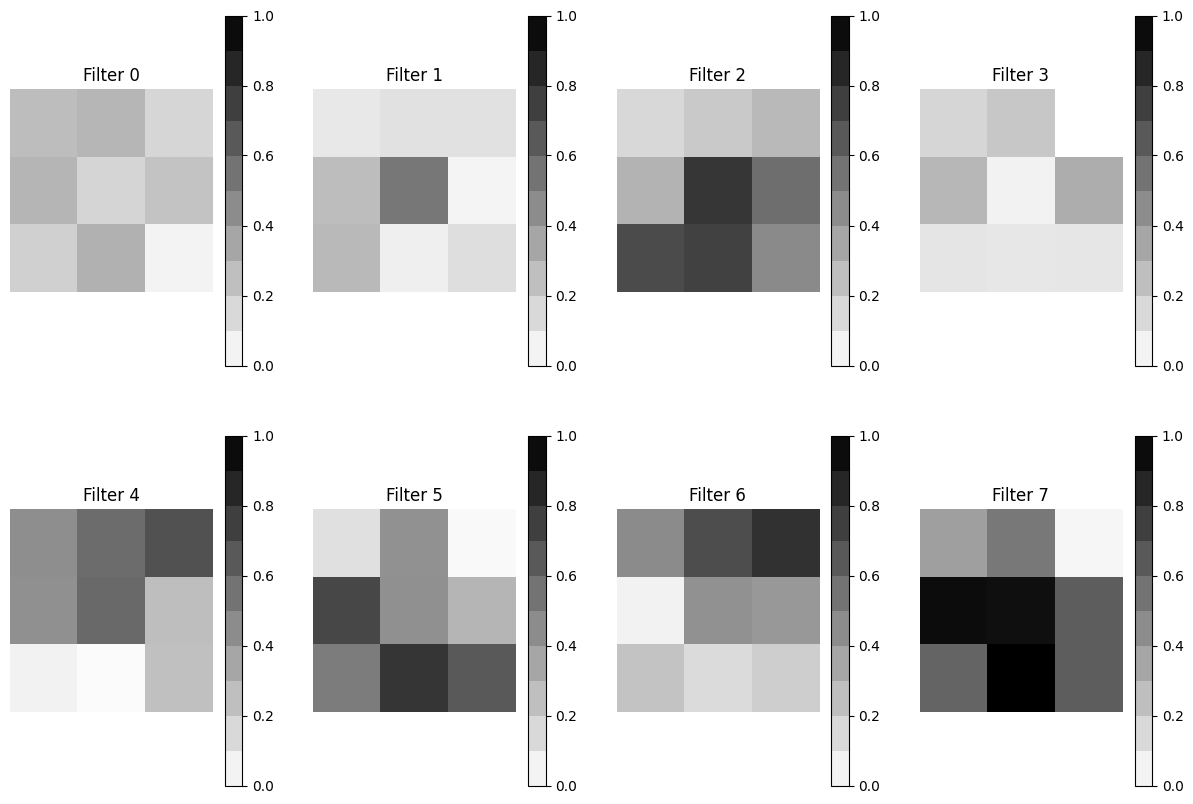

In [13]:
plt.figure(figsize=(15,10))

for i, filter in enumerate(filters):
    ax = plt.subplot(2, 4, i+1)
    img = plt.imshow(filters[i][0], cmap='gray_r', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Filter {i}')
    plt.colorbar(img, ax=ax, boundaries=np.arange(0, 1 + 0.1, 0.1))
plt.show()

### Dropout
 * Try adding dropout to your model.
 
You can add it between the convolutional layers and or in the fully connected part.

Remember to call `net.train()` and `net.eval()` to change the model from test to training state, so it knows when you want it to apply dropout.

## Already done?

Try to exploreextracting features at different layers of the model and visualizing the corresponding representation of your data using e.g. t-SNE or PCA. Try to understand how those two techniques differ

In [14]:
model.eval()

Network(
  (convolutional): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
  )
  (fully_connected): Sequential(
    (0): Linear(in_features=3136, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

In [18]:
### OBS
# https://medium.com/analytics-vidhya/pytorch-hooks-5909c7636fb
model.convolutional[0]

Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [26]:
# Define a hook to capture intermediate layer activations
def get_activation(layer_name):
    def hook(model, input, output):
        activation[layer_name] = output.detach()  # Store the output
    return hook

# Example: Register a hook for the 'conv1' layer
activation = {}  # A global dictionary to store layer outputs
layer_num=0
model.convolutional[0].register_forward_hook(get_activation(layer_num))  # Hook for 'conv1'

In [27]:
def extract_features(model, dataloader, device='cpu'):
    features = []
    labels = []
    model.to(device)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for data, label in dataloader:
            data = data.to(device)
            
            # Forward pass to trigger the hook
            _ = model(data)

            # Collect the hooked output from the global 'activation' dictionary
            output = activation['conv1']  # Make sure 'conv1' matches the layer name in the hook
            output = output.cpu().numpy()  # Move to CPU and convert to NumPy
            output = output.reshape(output.shape[0], -1)  # Flatten for further analysis
            
            features.append(output)
            labels.append(label.numpy())
    
    return np.concatenate(features), np.concatenate(labels)


In [22]:
def extract_features(model, dataloader, device='cpu'):
    features = []
    labels = []
    model.to(device)
    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(device)
            
            # Forward pass to trigger the hook
            _ = model(data)

            # Collect the hooked output
            output = activation.cpu().numpy()  # 'conv1' here, adjust as needed
            output = output.reshape(output.shape[0], -1)  # Flatten for further analysis
            

            features.append(output.cpu().numpy())
            labels.append(label.numpy())
    return np.concatenate(features), np.concatenate(labels)

In [28]:
features, labels = extract_features(model, train_loader, device='cpu')

AttributeError: 'Conv2d' object has no attribute 'convolutional'

In [29]:
# Hook function to store the layer's output in the global `activation` dictionary
def get_activation(layer_name):
    def hook(model, input, output):
        activation[layer_name] = output.detach()  # Store the output
    return hook

activation = {}  # Global dictionary to store activations

# Example: Register a hook for the first convolutional layer
layer_name = 'conv1'
model.convolutional[0].register_forward_hook(get_activation(layer_name))  # Hook for 'conv1'

def extract_features(model, dataloader, device='cpu'):
    features = []
    labels = []
    model.to(device)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for data, label in dataloader:
            data = data.to(device)
            
            # Forward pass to trigger the hook
            _ = model(data)

            # Collect the hooked output from the global 'activation' dictionary
            output = activation['conv1']  # Make sure 'conv1' matches the layer name in the hook
            output = output.cpu().numpy()  # Move to CPU and convert to NumPy
            output = output.reshape(output.shape[0], -1)  # Flatten for further analysis
            
            features.append(output)
            labels.append(label.numpy())
    
    return np.concatenate(features), np.concatenate(labels)

# Use this function to extract features from your dataloader
features, labels = extract_features(model, train_loader, device='cpu')


AttributeError: 'Conv2d' object has no attribute 'convolutional'

In [33]:
import torch

# Hook function to capture and store the activation
def get_activation(layer_name):
    def hook(model, input, output):
        activation[layer_name] = output.detach()  # Store the output
    return hook

activation = {}  # Dictionary to store activations

# Register a hook for the first Conv2d layer
model.convolutional.register_forward_hook(get_activation('convolution'))  # Register hook for 'conv1'

def extract_features(model, dataloader, device='cpu'):
    features = []
    labels = []
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for data, label in dataloader:
            data = data.to(device)
            
            # Forward pass to trigger the hook
            _ = model(data)

            # Collect the hooked output from the 'activation' dictionary
            output = activation['conv1']  # Make sure 'conv1' matches the hook
            output = output.cpu().numpy()  # Move to CPU and convert to NumPy
            output = output.reshape(output.shape[0], -1)  # Flatten for further analysis
            
            features.append(output)
            labels.append(label.numpy())

    return np.concatenat

features, labels = extract_features(model, train_loader, device='cpu')


AttributeError: 'Conv2d' object has no attribute 'convolutional'

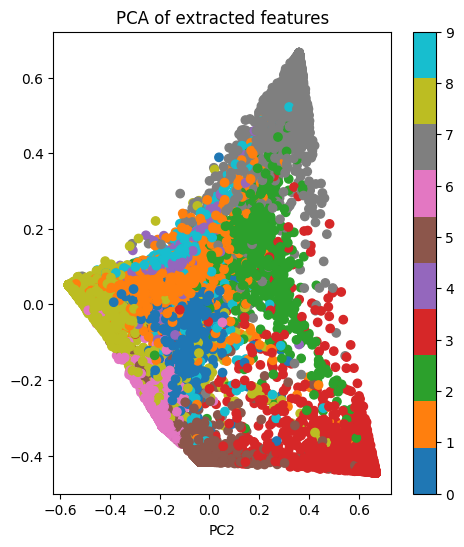

In [59]:
# Visualize using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10')
plt.title('PCA of extracted features')
plt.xlabel('PC1')
plt.xlabel('PC2')
plt.colorbar()
plt.show()

In [38]:
conv2 = model.convolutional[3].weight.data.cpu().numpy()

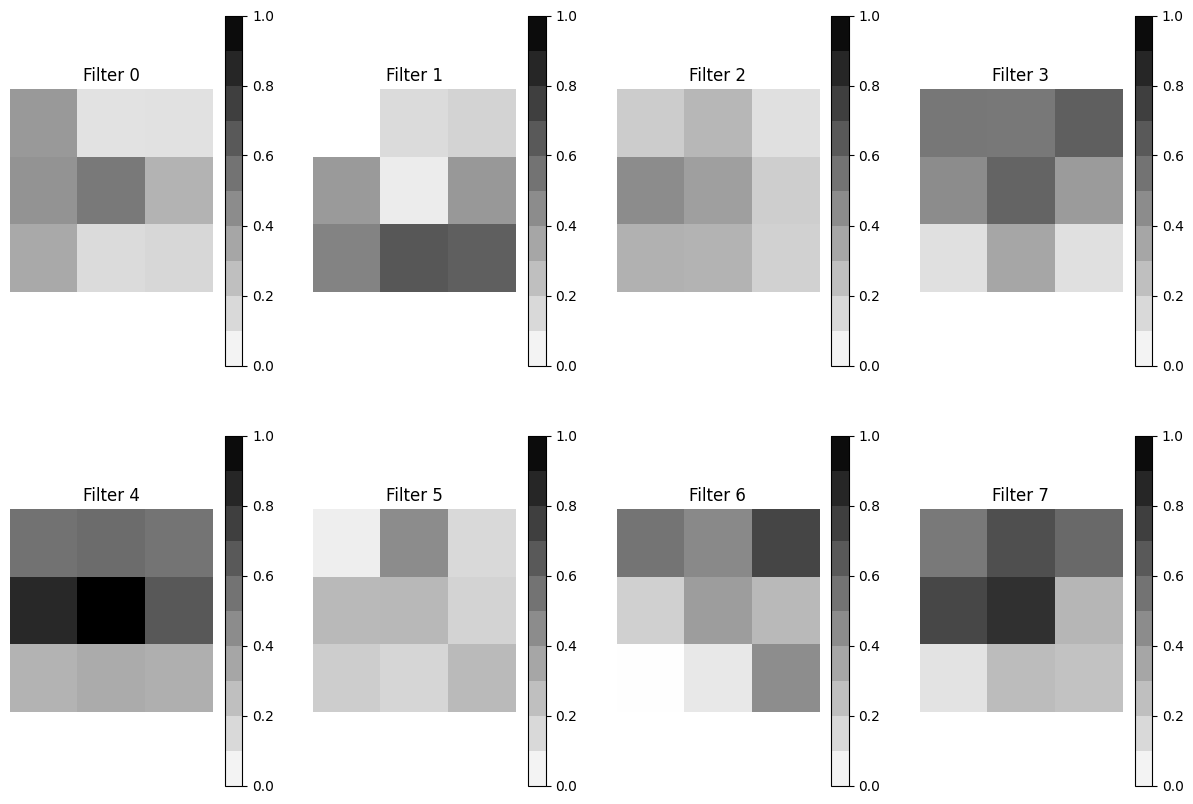

In [39]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = conv1.min(), conv1.max()
filters = (conv1 - f_min) / (f_max - f_min)

plt.figure(figsize=(15,10))

for i, filter in enumerate(filters):
    ax = plt.subplot(2, 4, i+1)
    img = plt.imshow(filters[i][0], cmap='gray_r', vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f'Filter {i}')
    plt.colorbar(img, ax=ax, boundaries=np.arange(0, 1 + 0.1, 0.1))
plt.show()